In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import torch
import torch.nn as nn

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
layer = 4
env_steps = Concept.load_concept_data()
model_path = QNetwork.find_newest_model()
model = QNetwork(frame_stacks=4, model_path=model_path)
print(f"Using model: {model_path}")

Using model: runs/20240128-235322/model_10000000.pt


In [4]:
# Remove concepts with no probe or score less than 0.5
test_concepts = []
for concept in concept_instances.values():
    probe, score = concept.load_torch_probe()
    if probe is not None and score > 0.5:
        test_concepts.append(concept)

In [5]:
concept = concept_instances['bullet close']
concept.prepare_data(env_steps)
probe, score = concept.load_torch_probe()

In [6]:
train_obs = torch.tensor(concept.train_obs).float()
test_obs = torch.tensor(concept.test_obs).float()
test_images = concept.test_images
train_values = torch.tensor(concept.train_values).float().unsqueeze(1)
test_values = torch.tensor(concept.test_values).float().unsqueeze(1)

In [7]:
# Assumes pixels 0-1 not 0-255
class ModelProbeOptimizer(nn.Module):
    def __init__(self, model, probe, probe_layer):
        super().__init__()
        self.probe = probe
        self.probe_layer = probe_layer

        # Extract the part of the model up to the target layer
        self.model_part = model.network[:probe_layer + 1]

    def forward(self, x):
        # Change to (batch, channel, width, height)
        if x.shape[1] == x.shape[2]:
            x = x.permute(0, 3, 1, 2)
            
        x = self.model_part(x)

        # Forward pass through the probe model
        probe_output = self.probe(x)
        return probe_output
    
optimizer_model = ModelProbeOptimizer(model, probe, layer)

In [8]:
optimizer_model(train_obs[0].unsqueeze(0) / 255.0)

tensor([[67.8367]], grad_fn=<AddmmBackward0>)

In [9]:
train_obs[5].unsqueeze(0).shape, train_obs[5].unsqueeze(0).dtype

(torch.Size([1, 84, 84, 12]), torch.float32)

### Optimize noise

In [10]:
def total_variation_loss(img):
    # Assuming img is of shape [batch_size, height, width, channels]
    height_variation = torch.sum(torch.abs(img[:, 1:, :, :] - img[:, :-1, :, :]))
    width_variation = torch.sum(torch.abs(img[:, :, 1:, :] - img[:, :, :-1, :]))
    # Normalize by the total number of elements in each variation to make the loss scale-invariant
    batch_size, height, width, channels = img.size()
    tv_loss = (height_variation / (batch_size * (height - 1) * width * channels) +
               width_variation / (batch_size * height * (width - 1) * channels))
    return tv_loss

In [18]:
lr = 0.001
iterations = 1000
loss_ratio = 1
layer = 4

optimizer_model = ModelProbeOptimizer(model, probe, layer)

# input_obs = torch.randint(0, 255, train_obs.shape[1:], dtype=torch.float).unsqueeze(0).requires_grad_(True)
#input_obs = torch.rand(train_obs.shape[1:]).unsqueeze(0).requires_grad_(True)
# input_obs = torch.FloatTensor(train_obs.shape[1:]).uniform_(0, 1).unsqueeze(0).requires_grad_(True)
input_obs = test_obs[-3].unsqueeze(0).clone() / 255.0
original_input_obs = input_obs.clone()
input_obs.requires_grad_(True)
print(input_obs.min(), input_obs.max(), input_obs.mean(), input_obs.shape, input_obs.dtype)
print(f"Initial Prediction: {optimizer_model(input_obs).item():.4f}")
optimizer = torch.optim.Adam([input_obs], lr=lr)

for i in range(iterations):
    optimizer.zero_grad()
    
    prediction = optimizer_model(input_obs)
    loss1 = -prediction
    loss2 = total_variation_loss(input_obs) + torch.norm(input_obs - original_input_obs, 1)
    loss = loss_ratio * loss1 + loss2

    if i % 100 == 0 or i == iterations - 1:
        print(f"Iteration {i:3d} - Loss1: {loss1.item():.4f}, Loss2: {loss2:.4f}, Total Loss: {loss.item():.4f}")

    loss.backward()
    optimizer.step()
    
    input_obs.data = input_obs.data.clamp(0, 1)
    
input_obs.data = input_obs.data.clamp(0, 1)
final_prediction = optimizer_model(input_obs)
print(f"Final Prediction: {final_prediction.item():.4f}")
_, acts_dict = model(input_obs * 255.0, return_acts=True)
acts = acts_dict[layer]
print(probe(acts))
input_obs.min(), input_obs.max(), input_obs.mean()

tensor(0., grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>) tensor(0.6534, grad_fn=<MeanBackward0>) torch.Size([1, 84, 84, 12]) torch.float32
Initial Prediction: 2.4740
Iteration   0 - Loss1: -2.4740, Loss2: 0.0103, Total Loss: -2.4637
Iteration 100 - Loss1: -53.8420, Loss2: 36.8773, Total Loss: -16.9647
Iteration 200 - Loss1: -183.8688, Loss2: 82.7091, Total Loss: -101.1597
Iteration 300 - Loss1: -359.8084, Loss2: 140.2493, Total Loss: -219.5591
Iteration 400 - Loss1: -668.6154, Loss2: 243.9456, Total Loss: -424.6699
Iteration 500 - Loss1: -1086.2737, Loss2: 376.5416, Total Loss: -709.7321
Iteration 600 - Loss1: -1529.5474, Loss2: 539.2211, Total Loss: -990.3262
Iteration 700 - Loss1: -2070.5942, Loss2: 747.0411, Total Loss: -1323.5531
Iteration 800 - Loss1: -2682.6069, Loss2: 981.9539, Total Loss: -1700.6531
Iteration 900 - Loss1: -3390.4602, Loss2: 1229.3345, Total Loss: -2161.1257
Iteration 999 - Loss1: -3997.2476, Loss2: 1460.3970, Total Loss: -2536.8506
Final Prediction

(tensor(0., grad_fn=<MinBackward1>),
 tensor(1., grad_fn=<MaxBackward1>),
 tensor(0.6520, grad_fn=<MeanBackward0>))

### Optmize test observation

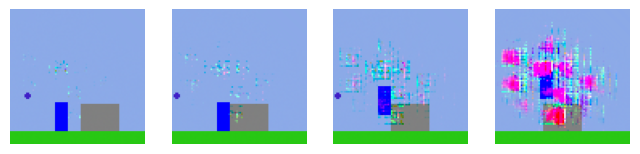

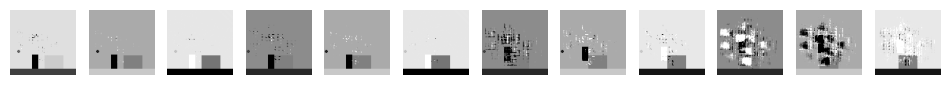

In [19]:
input_obs = input_obs.detach().numpy().squeeze()
# Plot each frame stack
# input_obs = input_obs.detach().numpy().squeeze().astype(np.uint8)
# input_obs = (train_obs[5].unsqueeze(0) / 255.0).detach().numpy().squeeze()
fig, axs = plt.subplots(1, 4, figsize=(8, 5))
for i in range(0, 12, 3):
    # Stack RGB channels
    img = np.stack([input_obs[:, :, i], input_obs[:, :, i+1], input_obs[:, :, i+2]], axis=2)
    img /= img.max()
    axs[i//3].imshow(img)
    axs[i//3].axis('off')
plt.show()

fig, axs = plt.subplots(1, 12, figsize=(12, 12))
for i in range(12):
    axs[i].imshow(input_obs[:, :, i], cmap='gray')
    axs[i].axis('off')
plt.show()

In [13]:
display_obs(example_obs, 'Input Observation')
display_obs(perturbation, 'Perturbation')
display_obs(perturbed_obs, 'Input + Pertubation Image')

NameError: name 'display_obs' is not defined

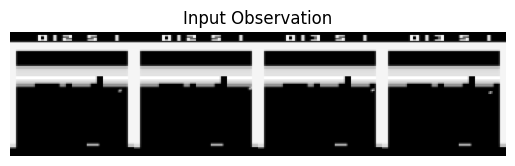

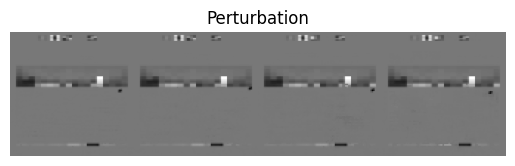

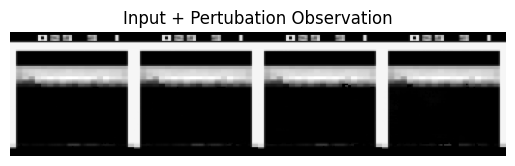

In [ ]:
display_obs(example_obs, 'Input Observation')
display_obs(perturbation, 'Perturbation')
display_obs(perturbed_obs, 'Input + Pertubation Observation')

# Deep dream of highest Q-value (not concept related)

In [ ]:
pertubation_lr = 0.001
iterations = 1000
loss_ratio = 0.5

activation = nn.Hardtanh(min_val=0, max_val=255.0)

# Initialize perturbation with small value
small_noise = torch.ones_like(example_obs) * 0.001
perturbation = small_noise.clone().detach().requires_grad_(True)
initial_prediction = q_network(activation(example_obs + perturbation * 255.0))
print(f"Initial Prediction: {initial_prediction}")

for i in range(iterations):
    perturbed_obs = torch.nn.functional.relu(activation(example_obs + perturbation * 255.0))
    
    q_values = q_network(perturbed_obs)
    
    loss1 = -torch.min(q_values)
    loss2 = torch.norm(perturbation, p=2)
    total_loss = loss_ratio * loss1 + loss2
    
    if i % 100 == 0:
        print(f"Iteration {i:3d} - Loss1: {loss1:.4f}, Loss2: {loss2:.4f}, Total Loss: {total_loss:.4f}")
    
    total_loss.backward()
    with torch.no_grad():
        perturbation -= pertubation_lr * perturbation.grad
        perturbation.grad.zero_()

perturbed_obs = torch.nn.functional.relu(activation(example_obs + perturbation * 255.0))
final_prediction = q_network(perturbed_obs)
print(f"Final Prediction: {final_prediction}")

Initial Prediction: tensor([[3.9394, 3.9424, 3.9156, 3.9295]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Iteration   0 - Loss1: -3.9156, Loss2: 0.1680, Total Loss: -1.7898
Iteration 100 - Loss1: -4.4068, Loss2: 0.1615, Total Loss: -2.0418
Iteration 200 - Loss1: -5.3115, Loss2: 0.2474, Total Loss: -2.4083
Iteration 300 - Loss1: -26.3559, Loss2: 0.7309, Total Loss: -12.4471
Iteration 400 - Loss1: -34.7435, Loss2: 1.1263, Total Loss: -16.2454
Iteration 500 - Loss1: -41.5474, Loss2: 1.4944, Total Loss: -19.2792
Iteration 600 - Loss1: -47.4032, Loss2: 1.8456, Total Loss: -21.8559
Iteration 700 - Loss1: -55.0831, Loss2: 2.2629, Total Loss: -25.2787
Iteration 800 - Loss1: -62.0965, Loss2: 2.6823, Total Loss: -28.3660
Iteration 900 - Loss1: -69.5450, Loss2: 3.1368, Total Loss: -31.6357
Final Prediction: tensor([[76.7097, 77.4225, 78.4650, 80.4427]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


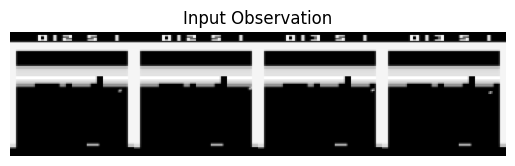

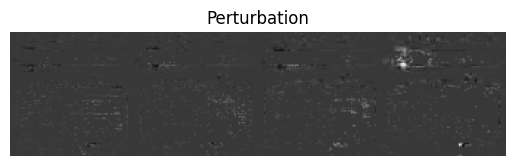

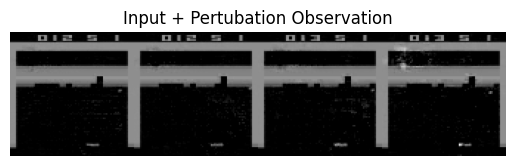

In [ ]:
display_obs(example_obs, 'Input Observation')
display_obs(perturbation, 'Perturbation')
display_obs(perturbed_obs, 'Input + Pertubation Observation')

# Train autoencoder up until a layer

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_variables):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, latent_variables)  # projects down to 64 latent variables
        )

    def forward(self, x):
        x = x / 255.0  # Normalizing input
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_variables):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_variables, 512),  # Projection back to flattened size
            nn.ReLU(),
            nn.Linear(512, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),  # Unflattening the tensor
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 4, 8, stride=4),
            nn.Sigmoid() # Using sigmoid activation to get values between 0 and 1
        )

    def forward(self, x):
        x = self.decoder(x)
        x = x * 255.0  # Scaling back the output
        return x

# Autoencoder that combines Encoder and Decoder
class Autoencoder(nn.Module):
    def __init__(self, latent_variables):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_variables)
        self.decoder = Decoder(latent_variables)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
criterion = nn.MSELoss()

learning_rate = 0.005
num_epochs = 500
batch_size = 128
latent_dim = 64

autoencoder = Autoencoder(latent_dim).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for i in range(0, len(train_obs), batch_size):
        batch = train_obs[i:i+batch_size]
        optimizer.zero_grad()
        outputs = autoencoder(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()

    # Validation
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}: Loss: {loss.item()} | ', end='')
        with torch.no_grad():
            test_loss = 0
            for i in range(0, len(test_obs), batch_size):
                batch = test_obs[i:i+batch_size]
                outputs = autoencoder(batch)
                loss = criterion(outputs, batch)
                test_loss += loss.item()
            print(f'Validation Loss: {test_loss / (len(test_obs) // batch_size)}')

Epoch 0/500: Loss: 319.9962463378906 | Validation Loss: 433.2907496861049
Epoch 10/500: Loss: 102.04466247558594 | Validation Loss: 137.24272809709822
Epoch 20/500: Loss: 57.00830841064453 | Validation Loss: 80.94753592354911
Epoch 30/500: Loss: 35.801048278808594 | Validation Loss: 59.42103086199079
Epoch 40/500: Loss: 25.519533157348633 | Validation Loss: 40.85437992640904
Epoch 50/500: Loss: 19.165603637695312 | Validation Loss: 34.660464423043386
Epoch 60/500: Loss: 19.250736236572266 | Validation Loss: 32.751220703125
Epoch 70/500: Loss: 15.66407585144043 | Validation Loss: 28.858983721051896
Epoch 80/500: Loss: 14.05420207977295 | Validation Loss: 27.857861382620676
Epoch 90/500: Loss: 12.446938514709473 | Validation Loss: 25.60623904636928
Epoch 100/500: Loss: 11.597274780273438 | Validation Loss: 23.54543549673898
Epoch 110/500: Loss: 10.971287727355957 | Validation Loss: 23.653418949672155
Epoch 120/500: Loss: 10.516484260559082 | Validation Loss: 23.362457002912247
Epoch 130/

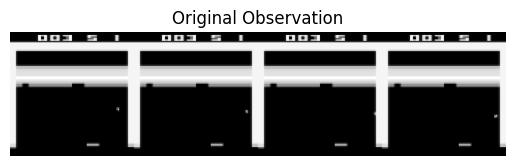

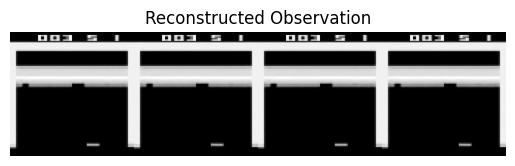

In [ ]:
image = test_obs[0].unsqueeze(0)
reconstructed_image = autoencoder(image)
display_obs(image, 'Original Observation')
display_obs(reconstructed_image, 'Reconstructed Observation')

# Train decoder on probe

In [ ]:
'''
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(512, 64 * 7 * 7),
            nn.ReLU(),
            nn.Linear(64 * 7 * 7, 4 * 84 * 84),
            nn.ReLU(),
        )
    
    def forward(self, x):
        x = self.decoder(x)
        x = x.view(-1, 4, 84, 84)
        return x * 255.0
'''

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(512, 64 * 7 * 7), # 512 hardcoded for layer in probe network
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)), # Matching the flattened dimension in the encoder
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 4, 8, stride=4),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder(x) * 255.0

decoder = Decoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.001)

In [ ]:
'''
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Shared layers (up to a certain point)
        self.shared_layers = nn.Sequential(
            nn.Linear(512, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2),
            nn.ReLU(),
        )

        # Image reconstruction branch
        self.image_layers = nn.Sequential(
            nn.ConvTranspose2d(32, 4, 8, stride=4),
            nn.Sigmoid()
        )

        self.scalar_layers = nn.Sequential(
            nn.Linear(12800, 100),  # Adjusted input size
            nn.ReLU(),
            nn.Linear(100, 2)  # Output two scalar values
        )

    def forward(self, x):
        shared_output = self.shared_layers(x)
        
        # Flatten for scalar branch
        flat_output = shared_output.view(shared_output.size(0), -1)

        # Debug: Print the shape of flat_output
        print(f"Shape of flat_output: {flat_output.shape}")

        # Get image and scalar outputs
        img_output = self.image_layers(shared_output)
        scalar_output = self.scalar_layers(flat_output)

        return img_output * 255.0, scalar_output

decoder = Decoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.001)
'''

'\nclass Decoder(nn.Module):\n    def __init__(self):\n        super(Decoder, self).__init__()\n\n        # Shared layers (up to a certain point)\n        self.shared_layers = nn.Sequential(\n            nn.Linear(512, 64 * 7 * 7),\n            nn.ReLU(),\n            nn.Unflatten(1, (64, 7, 7)),\n            nn.ConvTranspose2d(64, 64, 3, stride=1),\n            nn.ReLU(),\n            nn.ConvTranspose2d(64, 32, 4, stride=2),\n            nn.ReLU(),\n        )\n\n        # Image reconstruction branch\n        self.image_layers = nn.Sequential(\n            nn.ConvTranspose2d(32, 4, 8, stride=4),\n            nn.Sigmoid()\n        )\n\n        self.scalar_layers = nn.Sequential(\n            nn.Linear(12800, 100),  # Adjusted input size\n            nn.ReLU(),\n            nn.Linear(100, 2)  # Output two scalar values\n        )\n\n    def forward(self, x):\n        shared_output = self.shared_layers(x)\n        \n        # Flatten for scalar branch\n        flat_output = shared_output.

In [ ]:
encoded_features_train = probe_network.forward_features(train_obs)
encoded_features_train = encoded_features_train.detach()

encoded_features_test = probe_network.forward_features(test_obs)
encoded_features_test = encoded_features_test.detach()

num_epochs = 250
batch_size = 64

num_batches = len(encoded_features_train) // batch_size

print(f'|{"Epoch":^10}|{"Total Epochs":^14}|{"Train Loss":^20}|{"Validation Loss":^20}|')
for epoch in range(num_epochs):
    for i in range(num_batches):
        optimizer.zero_grad()
        # Get the i-th batch of images from train_obs and encoded_features_train
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        images = train_obs[start_idx:end_idx]
        batch_features = encoded_features_train[start_idx:end_idx]
        
        # Forward pass through decoder
        reconstructed_images = decoder(batch_features)

        # Compute the loss
        loss = criterion(reconstructed_images, images)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    if epoch % 50 == 0 or epoch == num_epochs - 1:
        with torch.no_grad():
            test_loss = 0
            for i in range(0, len(encoded_features_test), batch_size):
                batch = encoded_features_test[i:i+batch_size]
                outputs = decoder(batch)
                loss = criterion(outputs, test_obs[i:i+batch_size])
                test_loss += loss.item()
            print(f'|{epoch:^10}|{num_epochs:^14}|{loss.item():^20.4f}|{test_loss / (len(encoded_features_test) // batch_size):^20.4f}|')

|  Epoch   | Total Epochs |     Train Loss     |  Validation Loss   |
|    0     |     250      |      373.7975      |      456.9415      |
|    50    |     250      |      40.2899       |      49.1134       |
|   100    |     250      |      30.0249       |      34.4713       |
|   150    |     250      |      24.2296       |      29.0596       |
|   200    |     250      |      21.0497       |      26.5528       |
|   249    |     250      |      20.6434       |      26.9357       |


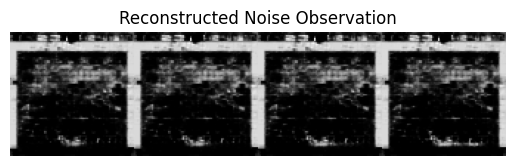

In [ ]:
# reconstruct observations
noise = torch.randn((1, encoded_features_train[0].shape[0])).to(device)
reconstructed_images = decoder(noise)
display_obs(reconstructed_images, 'Reconstructed Noise Observation')

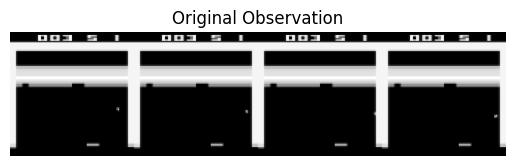

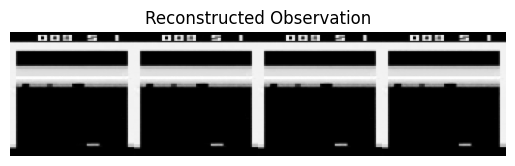

In [ ]:
image = test_obs[0].unsqueeze(0)
encoded = probe_network.forward_features(image)
reconstructed_images = decoder(encoded)
display_obs(image, 'Original Observation')
display_obs(reconstructed_images, 'Reconstructed Observation')

### Concept backprop with decoder

In [ ]:
# same code, but loss2 calculation and perturbation is different
# have to calculate probe values differently

pertubation_lr = 0.01
iterations = 1000
loss_ratio = 1000

# get shape of encoded features
acts_dummy = probe_network.forward_features(test_obs[0].unsqueeze(0))
perturbation = torch.zeros_like(acts_dummy, requires_grad=True).to(device)

initial_prediction = probe_network.forward_probe(probe_network.forward_features(example_obs) + perturbation)
print(f"Initial Prediction: {initial_prediction}")

for i in range(iterations):
    features = probe_network.forward_features(example_obs) + perturbation
    concept_value_pred = probe_network.forward_probe(features)
    decoded = decoder(features)
    loss1 = torch.norm(concept_value_pred - target_concept_value, p=1)
    loss2 = torch.norm(decoded - example_obs, p=2)
    total_loss = loss_ratio * loss1 + loss2

    if i % 100 == 0:
        print(f"Iteration {i:3d} - Loss1: {loss1:.4f}, Loss2: {loss2:.4f}, Total Loss: {total_loss:.4f}")
    total_loss.backward()

    # update perturbation
    with torch.no_grad():
        perturbation -= pertubation_lr * perturbation.grad
        perturbation.grad.zero_()

final_prediction = probe_network.forward_probe(probe_network.forward_features(example_obs) + perturbation)
print(f"Final Prediction: {final_prediction}")

Initial Prediction: tensor([[0.8707]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration   0 - Loss1: 0.8707, Loss2: 568.8887, Total Loss: 1439.5554
Iteration 100 - Loss1: 0.0013, Loss2: 484.2446, Total Loss: 485.5304
Iteration 200 - Loss1: 0.0007, Loss2: 484.8954, Total Loss: 485.5907
Iteration 300 - Loss1: 0.0005, Loss2: 481.3810, Total Loss: 481.8850
Iteration 400 - Loss1: 0.0004, Loss2: 479.1473, Total Loss: 479.5334
Iteration 500 - Loss1: 0.0003, Loss2: 477.8391, Total Loss: 478.1598
Iteration 600 - Loss1: 0.0003, Loss2: 476.2755, Total Loss: 476.5558
Iteration 700 - Loss1: 0.0002, Loss2: 475.4462, Total Loss: 475.6957
Iteration 800 - Loss1: 0.0002, Loss2: 474.9836, Total Loss: 475.2094
Iteration 900 - Loss1: 0.0002, Loss2: 474.6149, Total Loss: 474.8220
Final Prediction: tensor([[0.0002]], device='cuda:0', grad_fn=<SigmoidBackward0>)


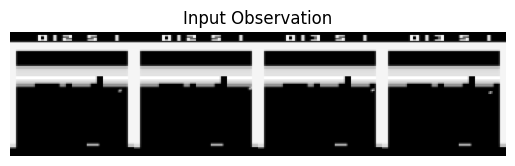

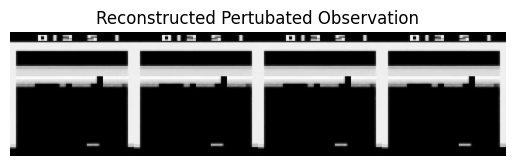

In [ ]:
display_obs(example_obs, 'Input Observation')
decoded = decoder(probe_network.forward_features(example_obs) + perturbation)
display_obs(decoded, 'Reconstructed Pertubated Observation')